In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import MathematicalProgram, Solve, SolverOptions, CommonSolverOption

In [171]:
def solve_prog(ad_mat, points, point_to_exclude):
    prog = MathematicalProgram()
    n = ad_mat.shape[0]
    prog = MathematicalProgram()
    v = prog.NewBinaryVariables(n)
    prog.AddLinearCost(-np.sum(v))
    lambdas = prog.NewContinuousVariables(1,2+1)
    gammas = prog.NewContinuousVariables(n)

    Points_mat = np.concatenate((points,np.ones((n,1))), axis =1)

    for i in range(0,n):
        for j in range(i+1,n):
            if ad_mat[i,j] == 0:
                prog.AddLinearConstraint(v[i] + v[j] <= 1)

    #for i in range(n):
    constraint1 = -Points_mat@lambdas[0,:]+gammas
    constraint2 = Points_mat[point_to_exclude, :]@lambdas[0,:]  #+ np.sum(gammas)
    for k in range(n):
        prog.AddLinearConstraint(constraint1[k] >=0)

    prog.AddLinearConstraint(constraint2>=1) #-v[point_to_exclude]
    
    for vi, gi in zip(v, gammas):
        prog.AddLinearConstraint(gi >= 6*(vi-1))

    for vi,gi in zip(v, gammas):
        prog.AddLinearConstraint(6*(1-vi)>= gi )


    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    return result.is_success(), result.GetSolution(v), result.GetSolution(lambdas), result.GetSolution(gammas)

def hyperplanepoints(l):
    l1, l2, l3  = l
    assert l1 !=0 or l2!=0
    dir = np.array([-l2 , l1])
    dir /= np.linalg.norm(dir)
    if l1 == 0:
        point_on_line = np.array([0, -l3/l2])
    elif l2 == 0:
        point_on_line = np.array([-l3/l1, 0])
    else:
        point_on_line = np.array([1, (-l3-l1)/l2])
    pts = np.array([ point_on_line + dir*l for l in np.linspace(-100,100, 100 )])
    return pts

success
binary assignment:  [0. 1. 1. 1. 0.]
lambda critical:  [-1. -1.  1.]
gamma critical:  [1. 0. 0. 0. 1.]


(-3, 3)

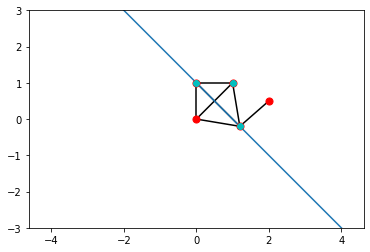

In [87]:
points = np.array([[0,0],
                   [1.2,-0.2],
                   [1,1],
                   [0,1],
                   [2,0.5]])

ad_mat = np.array([[0,1,1,1,0],
                   [1,0,1,1,1],
                   [1,1,0,1,0],
                   [1,1,1,0,0],
                   [0,1,0,0,0]])


        
fig = plt.figure()
plt.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)
for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            plt.plot(x,y, c = 'k')

ax = plt.gca()
ax.axis('equal')

success, v, lambdas, gammas = solve_prog(ad_mat, points, 0)
pts_idx = np.nonzero(v)[0]
lambdas = lambdas.squeeze()
clique = np.array([points[i] for i in pts_idx])
plt.scatter(clique[:, 0], clique[:, 1], c = 'c', zorder = 10)

print(f"{'success' if success else 'optimzation failed'}")
print('binary assignment: ', v)
print('lambda critical: ', lambdas)
print('gamma critical: ', gammas)
hpts = hyperplanepoints(lambdas)
plt.plot(hpts[:,0], hpts[:,1])
plt.xlim([-3,3])
plt.ylim([-3,3])

success
binary assignment:  [-0. -0. -0. -0.  1.  1. -0. -0. -0. -0. -0. -0. -0. -0.  1.  1. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
lambda critical:  [ 0.94444444 -1.11111111  1.75      ]
gamma critical:  [6. 6. 6. 6. 0. 0. 6. 6. 6. 6. 6. 6. 6. 6. 0. 0. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6.]


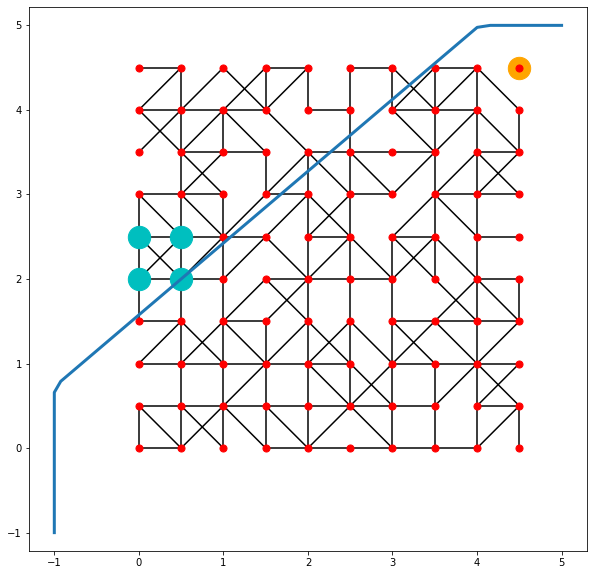

In [130]:
N = 10
sp = 0.5
np.random.seed(0)
points  = []
for i in range(N):
    for j in range(N):
        points.append(np.array([i*sp,j*sp]))
points = np.array(points)
ad_mat = np.zeros((N*N,N*N))
for i in range(N-1):
    for j in range(N-1):
        i1 = i + j*N
        i2 = i+1+ j*N
        i3 = i+1 +(j+1)*N
        i4 = i +(j+1)*N
        edges = np.where(np.random.rand(6)>0.5)[0]
        for e in edges:
            if e==0:
                ad_mat[i1,i2] =1
                ad_mat[i2,i1] =1
            if e==1:
                ad_mat[i2,i3] =1
                ad_mat[i3,i2] =1
            if e==2:
                ad_mat[i3,i4] =1
                ad_mat[i4,i3] =1
            if e==3:
                ad_mat[i4,i1] =1
                ad_mat[i1,i4] =1
            if e==4:
                ad_mat[i1,i3] =1
                ad_mat[i3,i1] =1
            if e==5:
                ad_mat[i2,i4] =1
                ad_mat[i4,i2] =1

# ad_mat[1,-1] = 1
# ad_mat[-1,1] = 1
# ad_mat[1,-2] = 1
# ad_mat[-2,1] = 1
# ad_mat[1,-3] = 1
# ad_mat[-3,1] = 1
# ad_mat[1,-4] = 1
# ad_mat[-4,1] = 1

# ad_mat[2,-1] = 1
# ad_mat[-1,2] = 1
# ad_mat[2,-2] = 1
# ad_mat[-2,2] = 1
# ad_mat[2,-3] = 1
# ad_mat[-3,2] = 1
# ad_mat[2,-4] = 1
# ad_mat[-4,2] = 1
ad_mat[4,5] = 1
ad_mat[5,4] = 1
fig,ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)


for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            ax.plot(x,y, c = 'k')

#ax = plt.gca()
ax.set_xlim([-1,N*sp])
ax.set_ylim([-1,N*sp])
ax.axis('equal')
excl =99
success, v, lambdas, gammas = solve_prog(ad_mat, points, excl)
ax.scatter(points[excl, 0], points[excl,1], c = 'orange', s = 500, zorder =1)
lambdas = lambdas.squeeze()

print(f"{'success' if success else 'optimzation failed'}")
print('binary assignment: ', v)
print('lambda critical: ', lambdas)
print('gamma critical: ', gammas)
pts_idx = np.where(np.abs(v)>=1e-4)[0]
clique = np.array([points[i] for i in pts_idx])
ax.scatter(clique[:, 0], clique[:, 1], c = 'c', s = 500, zorder = 10)

hpts = np.clip(hyperplanepoints(lambdas), -1, (N)*sp)
ax.plot(hpts[:,0], hpts[:,1], linewidth = 3, zorder = 20)



In [244]:
from ellipse_utils import switch_ellipse_description

def compute_outer_LJ_sphere(pts):
    dim = pts[0].shape[0]
    # pts = #[pt1, pt2]
    # for _ in range(2*dim):
    #     m = 0.5*(pt1+pt2) + eps*(np.random.rand(2,1)-0.5)
    #     pts.append(m)
    upper_triangular_indeces = []
    for i in range(dim-1):
        for j in range(i+1, dim):
            upper_triangular_indeces.append([i,j])

    upper_triangular_indeces = np.array(upper_triangular_indeces)
    prog = MathematicalProgram()
    inv_radius = prog.NewContinuousVariables(1, 'rad')
    A = inv_radius*np.eye(dim)
    b = prog.NewContinuousVariables(dim, 'b')
    prog.AddMaximizeLogDeterminantCost(A)
    for idx, pt in enumerate(pts):
        pt = pt.reshape(dim,1)
        S = prog.NewSymmetricContinuousVariables(dim+1, 'S')
        prog.AddPositiveSemidefiniteConstraint(S)
        prog.AddLinearEqualityConstraint(S[0,0] == 0.9)
        v = (A@pt + b.reshape(dim,1)).T
        c = (S[1:,1:]-np.eye(dim)).reshape(-1)
        for idx in range(dim):
            prog.AddLinearEqualityConstraint(S[0,1 + idx]-v[0,idx], 0 )
        for ci in c:
            prog.AddLinearEqualityConstraint(ci, 0 )

    prog.AddPositiveSemidefiniteConstraint(A) # eps * identity

    # for aij in A[upper_triangular_indeces[:,0], upper_triangular_indeces[:,1]]:
    #     prog.AddLinearConstraint(aij == 0)
    prog.AddPositiveSemidefiniteConstraint(10000*np.eye(dim)-A)

    sol = Solve(prog)
    if sol.is_success():
        HE, _, _ =switch_ellipse_description(sol.GetSolution(inv_radius)*np.eye(dim), sol.GetSolution(b))
    return HE


# ang = np.linspace(0, 2*np.pi, 100)
# pts = 2*np.array([[np.cos(ang)],[np.sin(ang)]]).squeeze().T

# HE = compute_outer_LJ_sphere(pts) 

# import matplotlib.pyplot as plt
# from ellipse_utils import plot_ellipse

# fig, ax = plt.subplots(1,1)
# ax.scatter(pts[:,0], pts[:,1])
# plot_ellipse(ax, HE, 100)

def max_clique_w_exclusion_points(adj_mat, graph_vertices, points_to_exclude):
    assert adj_mat.shape[0] == len(graph_vertices)
    assert graph_vertices[0, :].shape[0] == points_to_exclude.shape[1]
    
    dim = graph_vertices.shape[1]
    #compute radius of circumscribed sphere of all points to get soft margin size
    HS = compute_outer_LJ_sphere(np.concatenate((graph_vertices, points_to_exclude), axis=0))
    radius = 2*1/(HS.A()[0,0]+1e-6)
    n = adj_mat.shape[0]
    num_points_to_exclude = points_to_exclude.shape[0]


    prog = MathematicalProgram()
    v = prog.NewBinaryVariables(n)
    prog.AddLinearCost(-np.sum(v))
    
    #hyperplanes
    lambdas = prog.NewContinuousVariables(num_points_to_exclude, dim+1)
    #slack variables for soft margins
    gammas = prog.NewContinuousVariables(num_points_to_exclude, n)

    Points_mat = np.concatenate((points,np.ones((n,1))), axis =1)
    Exclusion_points_mat =  np.concatenate((points_to_exclude,np.ones((num_points_to_exclude,1))), axis =1)

    for i in range(0,n):
        for j in range(i+1,n):
            if ad_mat[i,j] == 0:
                prog.AddLinearConstraint(v[i] + v[j] <= 1)

    for i in range(num_points_to_exclude):
        constraint1 = -Points_mat@lambdas[i,:]+2*radius*gammas[i,:]
        constraint2 = Exclusion_points_mat[i,:]@lambdas[i,:]  #+ np.sum(gammas)
        for k in range(n):
            prog.AddLinearConstraint(constraint1[k] >=0)

        prog.AddLinearConstraint(constraint2>=1) #-v[point_to_exclude]

    for i in range(num_points_to_exclude):
        gammas_point_i = gammas[i, :]    
        for vi, gi in zip(v, gammas_point_i):
            prog.AddLinearConstraint(gi >= (vi-1))

        for vi,gi in zip(v, gammas_point_i):
            prog.AddLinearConstraint((1-vi)>= gi )


    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    return result.is_success(), result.GetSolution(v), result.GetSolution(lambdas), result.GetSolution(gammas)
    

average time = 0.18 over 10 tries, with 5 points excluded, on a graph of size 100
success
binary assignment:  [-0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0. -0.  0. -0.  1. -0. -0. -0.  1. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0.  0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0.
 -0.  1. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  1. -0.  0. -0. -0. -0.
 -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
  0. -0. -0. -0. -0. -0. -0.  0. -0. -0.]
lambda critical:  [[  2.           0.          -8.        ]
 [  0.          24.83272677 -98.33090706]
 [-24.83272677  -1.          13.41636338]
 [  0.          -2.           3.        ]
 [  0.28571429  12.41636338 -43.74298613]]


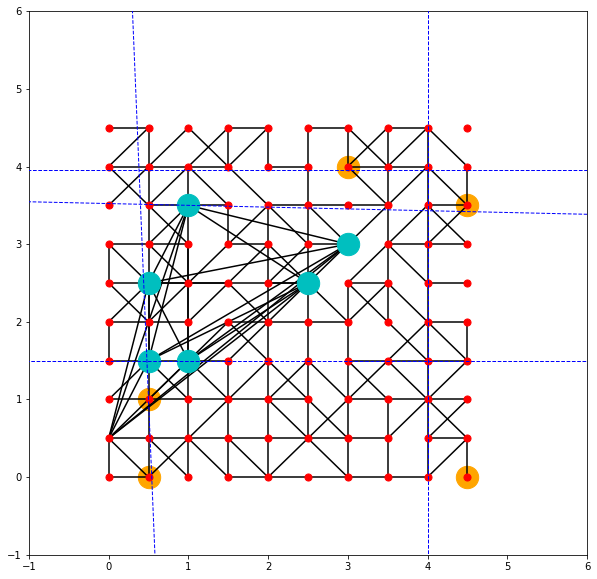

In [248]:
N = 10
sp = 0.5
np.random.seed(0)
points  = []
for i in range(N):
    for j in range(N):
        points.append(np.array([i*sp,j*sp]))
points = np.array(points)
ad_mat = np.zeros((N*N,N*N))
for i in range(N-1):
    for j in range(N-1):
        i1 = i + j*N
        i2 = i+1+ j*N
        i3 = i+1 +(j+1)*N
        i4 = i +(j+1)*N
        edges = np.where(np.random.rand(6)>0.5)[0]
        for e in edges:
            if e==0:
                ad_mat[i1,i2] =1
                ad_mat[i2,i1] =1
            if e==1:
                ad_mat[i2,i3] =1
                ad_mat[i3,i2] =1
            if e==2:
                ad_mat[i3,i4] =1
                ad_mat[i4,i3] =1
            if e==3:
                ad_mat[i4,i1] =1
                ad_mat[i1,i4] =1
            if e==4:
                ad_mat[i1,i3] =1
                ad_mat[i3,i1] =1
            if e==5:
                ad_mat[i2,i4] =1
                ad_mat[i4,i2] =1

# ad_mat[1,-1] = 1
# ad_mat[-1,1] = 1
# ad_mat[1,-2] = 1
# ad_mat[-2,1] = 1
# ad_mat[1,-3] = 1
# ad_mat[-3,1] = 1
# ad_mat[1,-4] = 1
# ad_mat[-4,1] = 1

# ad_mat[2,-1] = 1
# ad_mat[-1,2] = 1
# ad_mat[2,-2] = 1
# ad_mat[-2,2] = 1
# ad_mat[2,-3] = 1
# ad_mat[-3,2] = 1
# ad_mat[2,-4] = 1
# ad_mat[-4,2] = 1
clique = [1, 13, 23, 15, 27, 55, 66]
for i,c in enumerate(clique[:-1]):
    for c2 in clique[i+1:]:
        ad_mat[c,c2] = 1
        ad_mat[c2,c] = 1

fig,ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)


for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            ax.plot(x,y, c = 'k')

#ax = plt.gca()
ax.set_xlim([-1,1+N*sp])
ax.set_ylim([-1,1+N*sp])
#ax.axis('equal')
#excl =99
excl = 5
points_to_exclude =  points[np.random.choice(N**2,excl), :]

import time
tries = 10
t1 = time.time()
for _ in range(tries):
    success, v, lambdas, gammas = max_clique_w_exclusion_points(ad_mat, points, points_to_exclude)
t2 = time.time()
print(f"average time = {(t2-t1)/tries:.2f} over {tries} tries, with {excl} points excluded, on a graph of size {N**2}")

ax.scatter(points_to_exclude[:, 0], points_to_exclude[:,1], c = 'orange', s = 500, zorder =1)
#lambdas = lambdas.squeeze()

print(f"{'success' if success else 'optimzation failed'}")
print('binary assignment: ', v)
print('lambda critical: ', lambdas)
#print('gamma critical: ', gammas)
pts_idx = np.where(np.abs(v)>=1e-4)[0]
clique = np.array([points[i] for i in pts_idx])
ax.scatter(clique[:, 0], clique[:, 1], c = 'c', s = 500, zorder = 10)

for i in range(lambdas.shape[0]):
    lamb = lambdas[i,:]
    hpts = hyperplanepoints(lamb)#np.clip(hyperplanepoints(lamb), -1, (N)*sp)
    ax.plot(hpts[:,0], hpts[:,1], linewidth = 1, linestyle = '--', c= 'b', zorder = 20)

average time = 8.30 over 10 tries, with 50 points excluded, on a graph of size 400
success
binary assignment:  [-0. -0. -0.  0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  1. -0.  1. -0. -0.
 -0. -0. -0. -0. -0.  1. -0. -0. -0.  1. -0. -0. -0. -0. -0.  0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. 

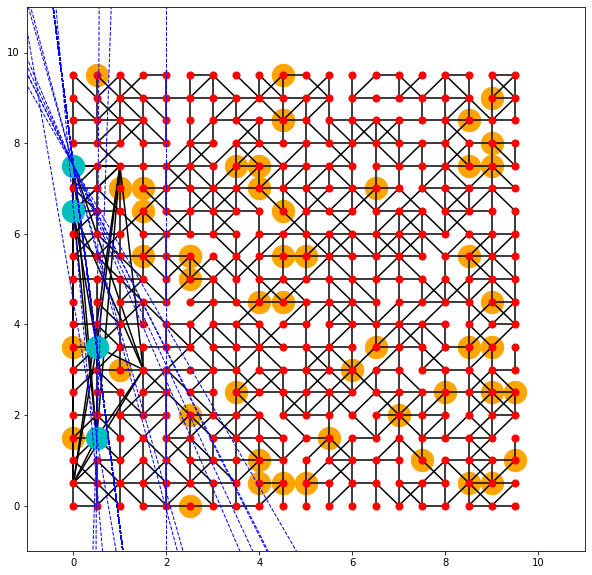

In [243]:
N = 20
sp = 0.5
np.random.seed(0)
points  = []
for i in range(N):
    for j in range(N):
        points.append(np.array([i*sp,j*sp]))
points = np.array(points)
ad_mat = np.zeros((N*N,N*N))
for i in range(N-1):
    for j in range(N-1):
        i1 = i + j*N
        i2 = i+1+ j*N
        i3 = i+1 +(j+1)*N
        i4 = i +(j+1)*N
        edges = np.where(np.random.rand(6)>0.5)[0]
        for e in edges:
            if e==0:
                ad_mat[i1,i2] =1
                ad_mat[i2,i1] =1
            if e==1:
                ad_mat[i2,i3] =1
                ad_mat[i3,i2] =1
            if e==2:
                ad_mat[i3,i4] =1
                ad_mat[i4,i3] =1
            if e==3:
                ad_mat[i4,i1] =1
                ad_mat[i1,i4] =1
            if e==4:
                ad_mat[i1,i3] =1
                ad_mat[i3,i1] =1
            if e==5:
                ad_mat[i2,i4] =1
                ad_mat[i4,i2] =1

# ad_mat[1,-1] = 1
# ad_mat[-1,1] = 1
# ad_mat[1,-2] = 1
# ad_mat[-2,1] = 1
# ad_mat[1,-3] = 1
# ad_mat[-3,1] = 1
# ad_mat[1,-4] = 1
# ad_mat[-4,1] = 1

# ad_mat[2,-1] = 1
# ad_mat[-1,2] = 1
# ad_mat[2,-2] = 1
# ad_mat[-2,2] = 1
# ad_mat[2,-3] = 1
# ad_mat[-3,2] = 1
# ad_mat[2,-4] = 1
# ad_mat[-4,2] = 1
clique = [1, 13, 23, 15, 27, 55, 66]
for i,c in enumerate(clique[:-1]):
    for c2 in clique[i+1:]:
        ad_mat[c,c2] = 1
        ad_mat[c2,c] = 1

fig,ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)


for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            ax.plot(x,y, c = 'k')

#ax = plt.gca()
ax.set_xlim([-1,1+N*sp])
ax.set_ylim([-1,1+N*sp])
#ax.axis('equal')
#excl =99
excl = 50
points_to_exclude =  points[np.random.choice(N**2,excl), :]

import time
tries = 10
t1 = time.time()
for _ in range(tries):
    success, v, lambdas, gammas = max_clique_w_exclusion_points(ad_mat, points, points_to_exclude)
t2 = time.time()
print(f"average time = {(t2-t1)/tries:.2f} over {tries} tries, with {excl} points excluded, on a graph of size {N**2}")

ax.scatter(points_to_exclude[:, 0], points_to_exclude[:,1], c = 'orange', s = 500, zorder =1)
#lambdas = lambdas.squeeze()

print(f"{'success' if success else 'optimzation failed'}")
print('binary assignment: ', v)
print('lambda critical: ', lambdas)
#print('gamma critical: ', gammas)
pts_idx = np.where(np.abs(v)>=1e-4)[0]
clique = np.array([points[i] for i in pts_idx])
ax.scatter(clique[:, 0], clique[:, 1], c = 'c', s = 500, zorder = 10)

for i in range(lambdas.shape[0]):
    lamb = lambdas[i,:]
    hpts = hyperplanepoints(lamb)#np.clip(hyperplanepoints(lamb), -1, (N)*sp)
    ax.plot(hpts[:,0], hpts[:,1], linewidth = 1, linestyle = '--', c= 'b', zorder = 20)

In [239]:
from independent_set_solver import solve_max_independent_set_integer

tries = 10
t1 = time.time()
for _ in range(tries):
    adj_curr = ad_mat.copy()
    adj_curr = 1- adj_curr
    np.fill_diagonal(adj_curr, 0)
    val = solve_max_independent_set_integer(adj_curr)
t2 = time.time()
print(f"average time = {(t2-t1)/tries} over {tries} tries, with {0} points excluded, on a graph of size {N**2}")

average time = 0.09878907203674317 over 10 tries, with 0 points excluded, on a graph of size 100


In [234]:
val

(7.0, (array([ 1, 13, 15, 23, 27, 55, 66]),))

In [99]:
A = np.array([lamb_sol[0], lamb_sol[1]]).reshape(1,2)
b = np.array([lamb_sol[2]])
np.linalg.solve(A.T@A,A.T@b.reshape(1,1))

LinAlgError: Singular matrix

In [98]:
A.T@b.reshape(1,1)

array([[-2.],
       [ 0.]])

In [96]:
A.shape

(2, 1)

In [41]:
np.ones((1,n))@gammas[i,:]

array([<Expression "(x(4,0) + x(4,1) + x(4,2) + x(4,3) + x(4,4))">],
      dtype=object)

In [28]:
np.matmul(Points_mat,lambdas[i,:])

array([<Expression "x(0,2)">, <Expression "(x(0,0) + x(0,2))">,
       <Expression "(x(0,0) + x(0,1) + x(0,2))">,
       <Expression "(x(0,1) + x(0,2))">,
       <Expression "(2 * x(0,0) + 0.5 * x(0,1) + x(0,2))">], dtype=object)